# A Recurrent Network using Keras in TensorFlow

This notebook shows how we can train an RNN
(recurrent neural network) using the `tf.keras` interface.

TensorFlow comes pre-packages with some imdb movie reviews
that are labeled for positive or negative sentament. We'll build a
classifier that learns to label new reviews as good or bad.

This dataset was also used in Koan 3.

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import numpy as np

# Print out the TensorFlow version to help others reproduce this notebook.
print(tf.__version__)

1.9.0


## Load in the data

In [2]:
imdb = keras.datasets.imdb

NUM_WORDS  = 1000  # Keep this many words (throw out least popular).
INDEX_FROM = 3    # Initial index of kept words.

(X_train_, y_train), (X_test_, y_test) = imdb.load_data(
    num_words = NUM_WORDS,
    index_from = INDEX_FROM
)

## Convert data to fixed-length time series

In [3]:
from tensorflow.keras.preprocessing import sequence

We'll use `pad_sequences()` to constrain (shortening or lengthening) the review lengths
to the same value. Here's an example of how this function works:

In [4]:
sequence.pad_sequences(X_train_[:15], maxlen=10)

array([[  2, 113, 103,  32,  15,  16,   2,  19, 178,  32],
       [ 52, 154, 462,  33,  89,  78, 285,  16, 145,  95],
       [106, 607, 624,  35, 534,   6, 227,   7, 129, 113],
       [ 26,  49,   2,  15, 566,  30, 579,  21,  64,   2],
       [ 19,  14,   5,   2,   6, 226, 251,   7,  61, 113],
       [  4, 226,  65,  12,  43, 127,  24,   2,  10,  10],
       [108,   7,   4,   2,   5,   2,  81,  55,  52,   2],
       [ 28,   6,  22,  15, 122,  24,   2,  72,  33,  32],
       [  9,  31,   7,   4, 118,   2,  13,  28, 126, 110],
       [  4,  58,   5,   4, 816,   9, 243,   7,  43,  50],
       [ 31,   7,   4, 118,   7,   4,   2, 545,   2, 829],
       [ 13, 202,  12,   2,   5,   6, 320,  46,   7, 457],
       [  8, 130,  56, 547,   2,   5,   2, 851,  14,   2],
       [  9, 170,  23,  11,   2, 134, 504,   2,   2,   2],
       [  2,   2,   2, 175,   2,  11,   4,   2, 543,   2]], dtype=int32)

Let's make an informed decision as to what length to constrain
the reviews to. Shorter lengths allow for faster processing at
the expense of losing data from longer reviews. A good length
includes most of the data, but does not waste time with many
padded zeros.

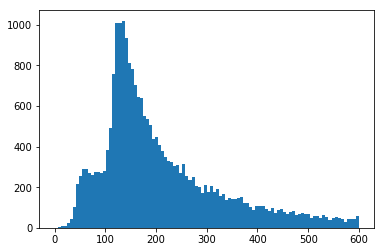

In [5]:
# Get a sense for how many reviews exist at various lengths.

review_lens = np.array([len(x) for x in X_train_])
plt.hist(review_lens, bins=100, range=(0, 600))
plt.show()

**Q**: How many reviews will we cover completely with a max length of 300?

In [6]:
fixed_len = 300
np.sum(review_lens < fixed_len) / len(review_lens)

0.76204

**A**: About 76%.

That seems like a reasonable compromise between coverage and length. No one reads overly-verbose movie reviews anyway ;)

In [7]:
X_train = sequence.pad_sequences(X_train_, maxlen=fixed_len)
X_test  = sequence.pad_sequences(X_test_,  maxlen=fixed_len)

# Set up the keras model

In [8]:
layers = keras.layers

In [9]:
wordvec_len = 100

model = keras.Sequential()
model.add(layers.Embedding(NUM_WORDS, wordvec_len))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

In [10]:
# Train the model.

n_epochs = 20
history = model.fit(X_train, y_train, epochs=n_epochs, verbose=0, validation_split=0.1)

/Users/tylerneylon/work/tfkoans/tfkoans-env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


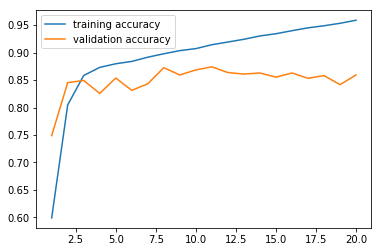

In [11]:
# Plot the training and validation accuracy over time.

epochs = range(1, n_epochs + 1)

plt.plot(epochs, history.history['acc'], label='training accuracy')
plt.plot(epochs, history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

### Compute the test-set accuracy

In [12]:
results = model.evaluate(X_test, y_test)

print()
print('Test accuracy:')
print(results[1])

25000/25000 [==============================] - 60s 2ms/step

Test accuracy:
0.85856


# Set up a regularized model

The idea here is to see if we can improve performance by reducing
the overfitting apparent in the above model.

In [17]:
regd_model = keras.Sequential()
regd_model.add(layers.Embedding(NUM_WORDS, wordvec_len))
regd_model.add(layers.LSTM(
    32,  # Number of output units.
    dropout = 0.1,
    recurrent_dropout = 0.5
))
regd_model.add(layers.Dense(1, activation='sigmoid'))

regd_model.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

In [18]:
# Train the model.

# We train this one longer because regularized networks often
# take longer to achieve the same training accuracy as their
# unregularized counterparts.

n_epochs = 40
regd_history = regd_model.fit(X_train, y_train, epochs=n_epochs, verbose=0, validation_split=0.1)

/Users/tylerneylon/work/tfkoans/tfkoans-env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


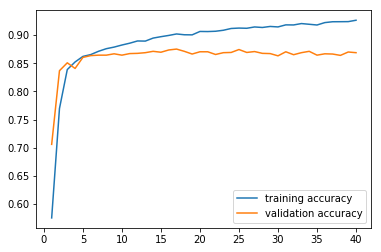

In [19]:
# Plot the training and validation accuracy over time.

epochs = range(1, n_epochs + 1)

plt.plot(epochs, regd_history.history['acc'], label='training accuracy')
plt.plot(epochs, regd_history.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

### Compute the test-set accuracy

In [21]:
results = regd_model.evaluate(X_test, y_test)

print()
print('Test accuracy (using the regularized network):')
print(results[1])

25000/25000 [==============================] - 84s 3ms/step

Test accuracy (using the regularized network):
0.88044
